# AIDS Clasification Project

- explanations of complete set of features can be found in this <a href="https://www.kaggle.com/code/aadarshvelu/aids-classification-eda-acc-91/input">link</a>.

## Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.svm import LinearSVC, SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier

import optuna
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import reciprocal, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, r2_score

import warnings
warnings.filterwarnings("ignore")

### Macros

In [25]:
num_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
cat_cols = ["trt", "hemo", "homo", "drugs", "karnof", "oprior", "z30",
            "race", "gender", "str2", "strat", "symptom", "treat", "offtrt"]
clr = sns.color_palette("bright")

## Exploratory Data Analysis

In [26]:
import pandas as pd
df = pd.read_csv("data/AIDS_Classification.csv")
df.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [27]:
#Null entry check
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,race,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
#duplicate check
print(f"Total number of duplicate rows: {df.duplicated().sum()}")

Total number of duplicate rows: 0


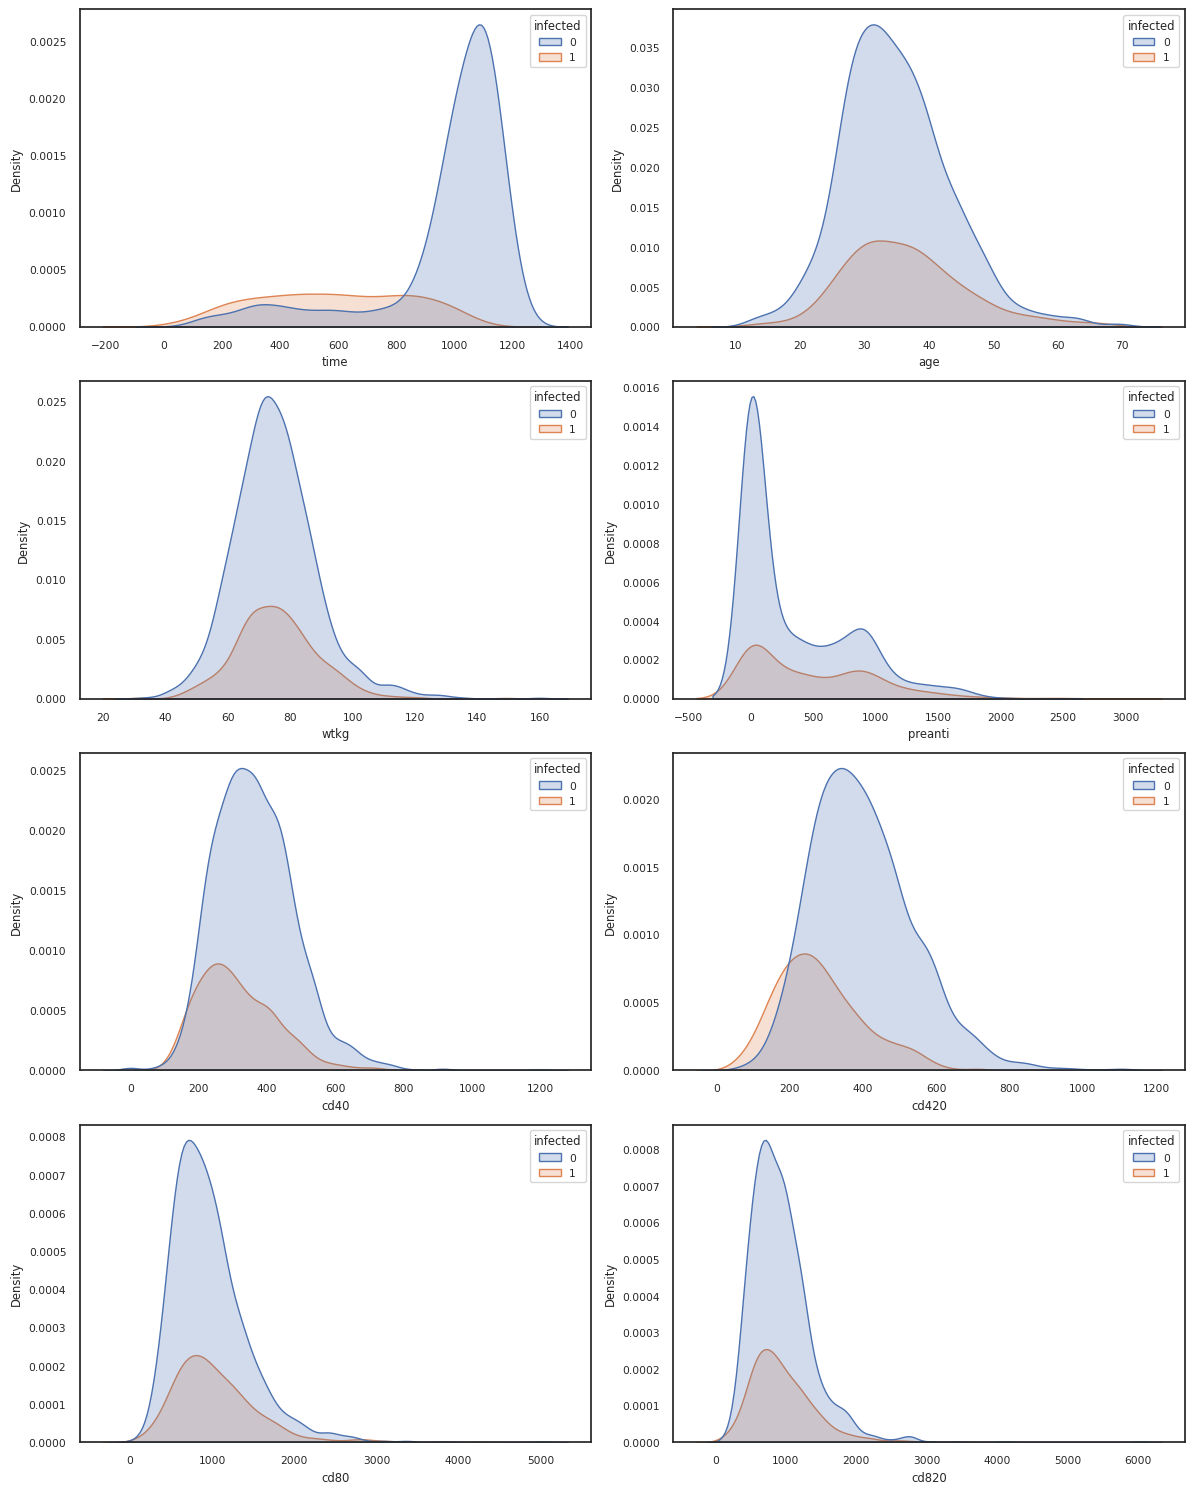

In [30]:
#Distribution of Numerical Variables
plt.figure(figsize=(12,15))

for i, col in enumerate(num_cols):
    plt.subplot(4,2, i+1)
    sns.kdeplot(data=df, x=col, shade=True, hue="infected", color=clr)
plt.tight_layout()
plt.show()

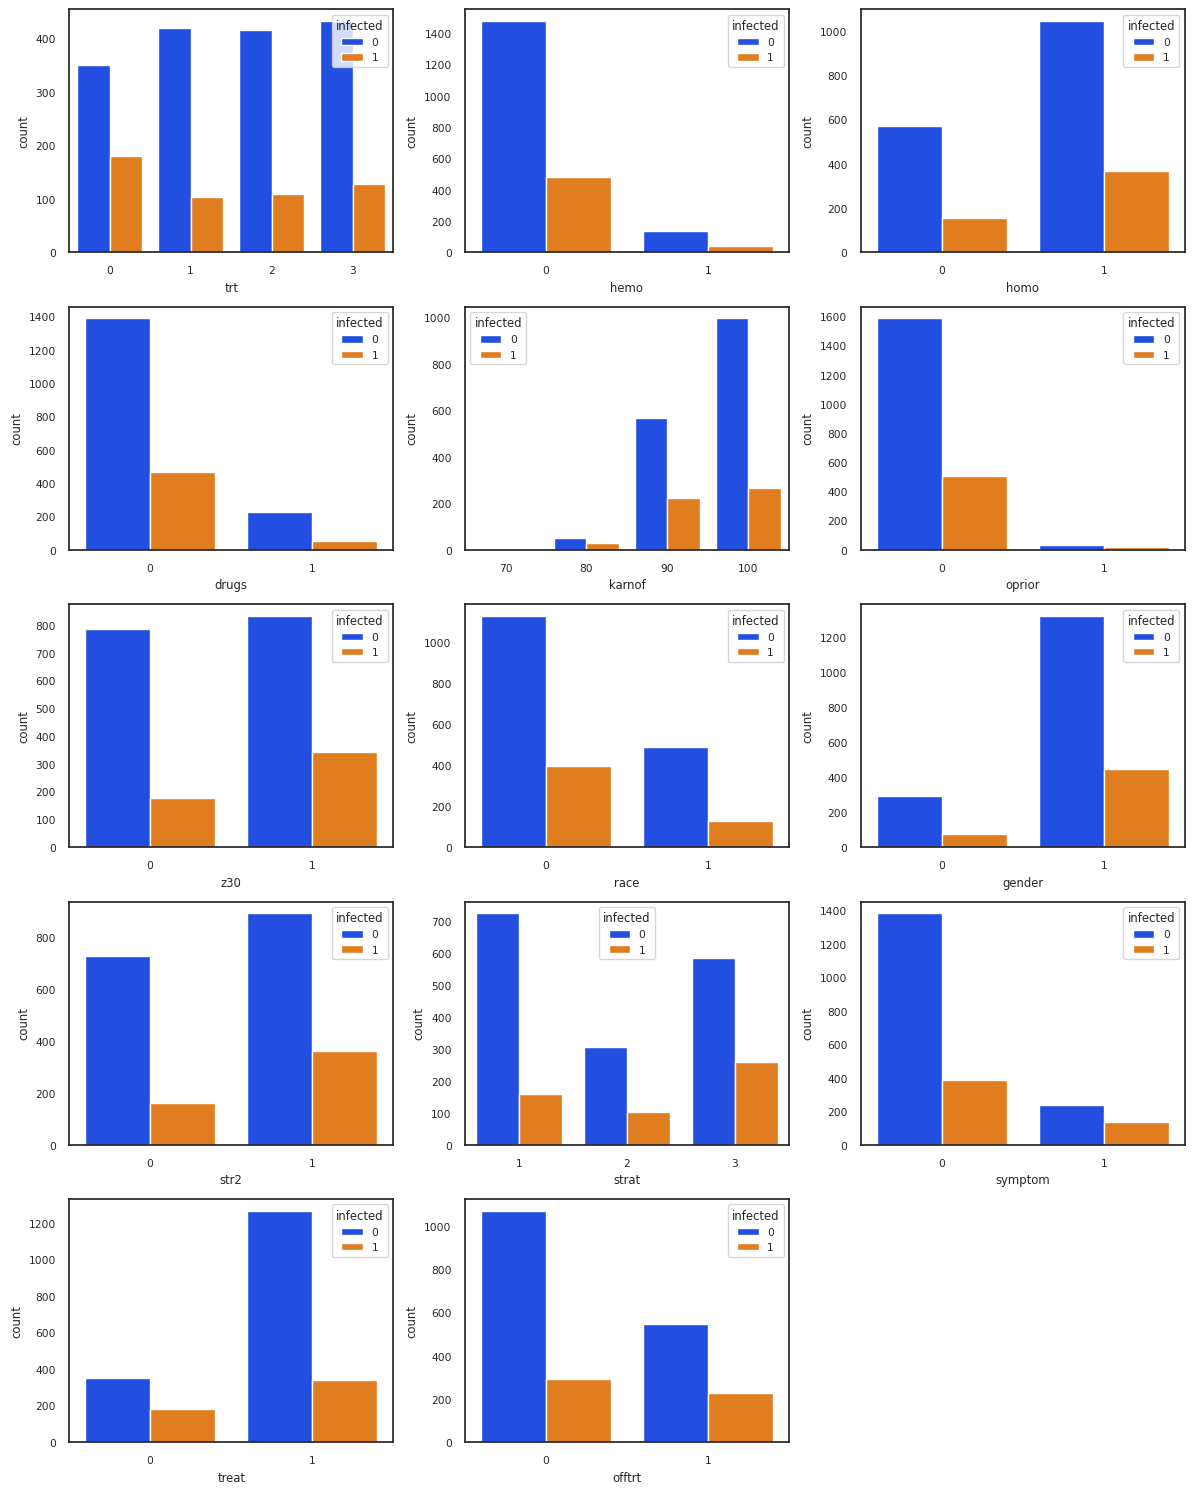

In [31]:
#Countplot of Discrete Variables
plt.figure(figsize=(12,15))

for i, col in enumerate(cat_cols):
    plt.subplot(5,3, i+1)
    sns.countplot(data=df, x=col, hue="infected", palette=clr)
plt.tight_layout()
plt.show()

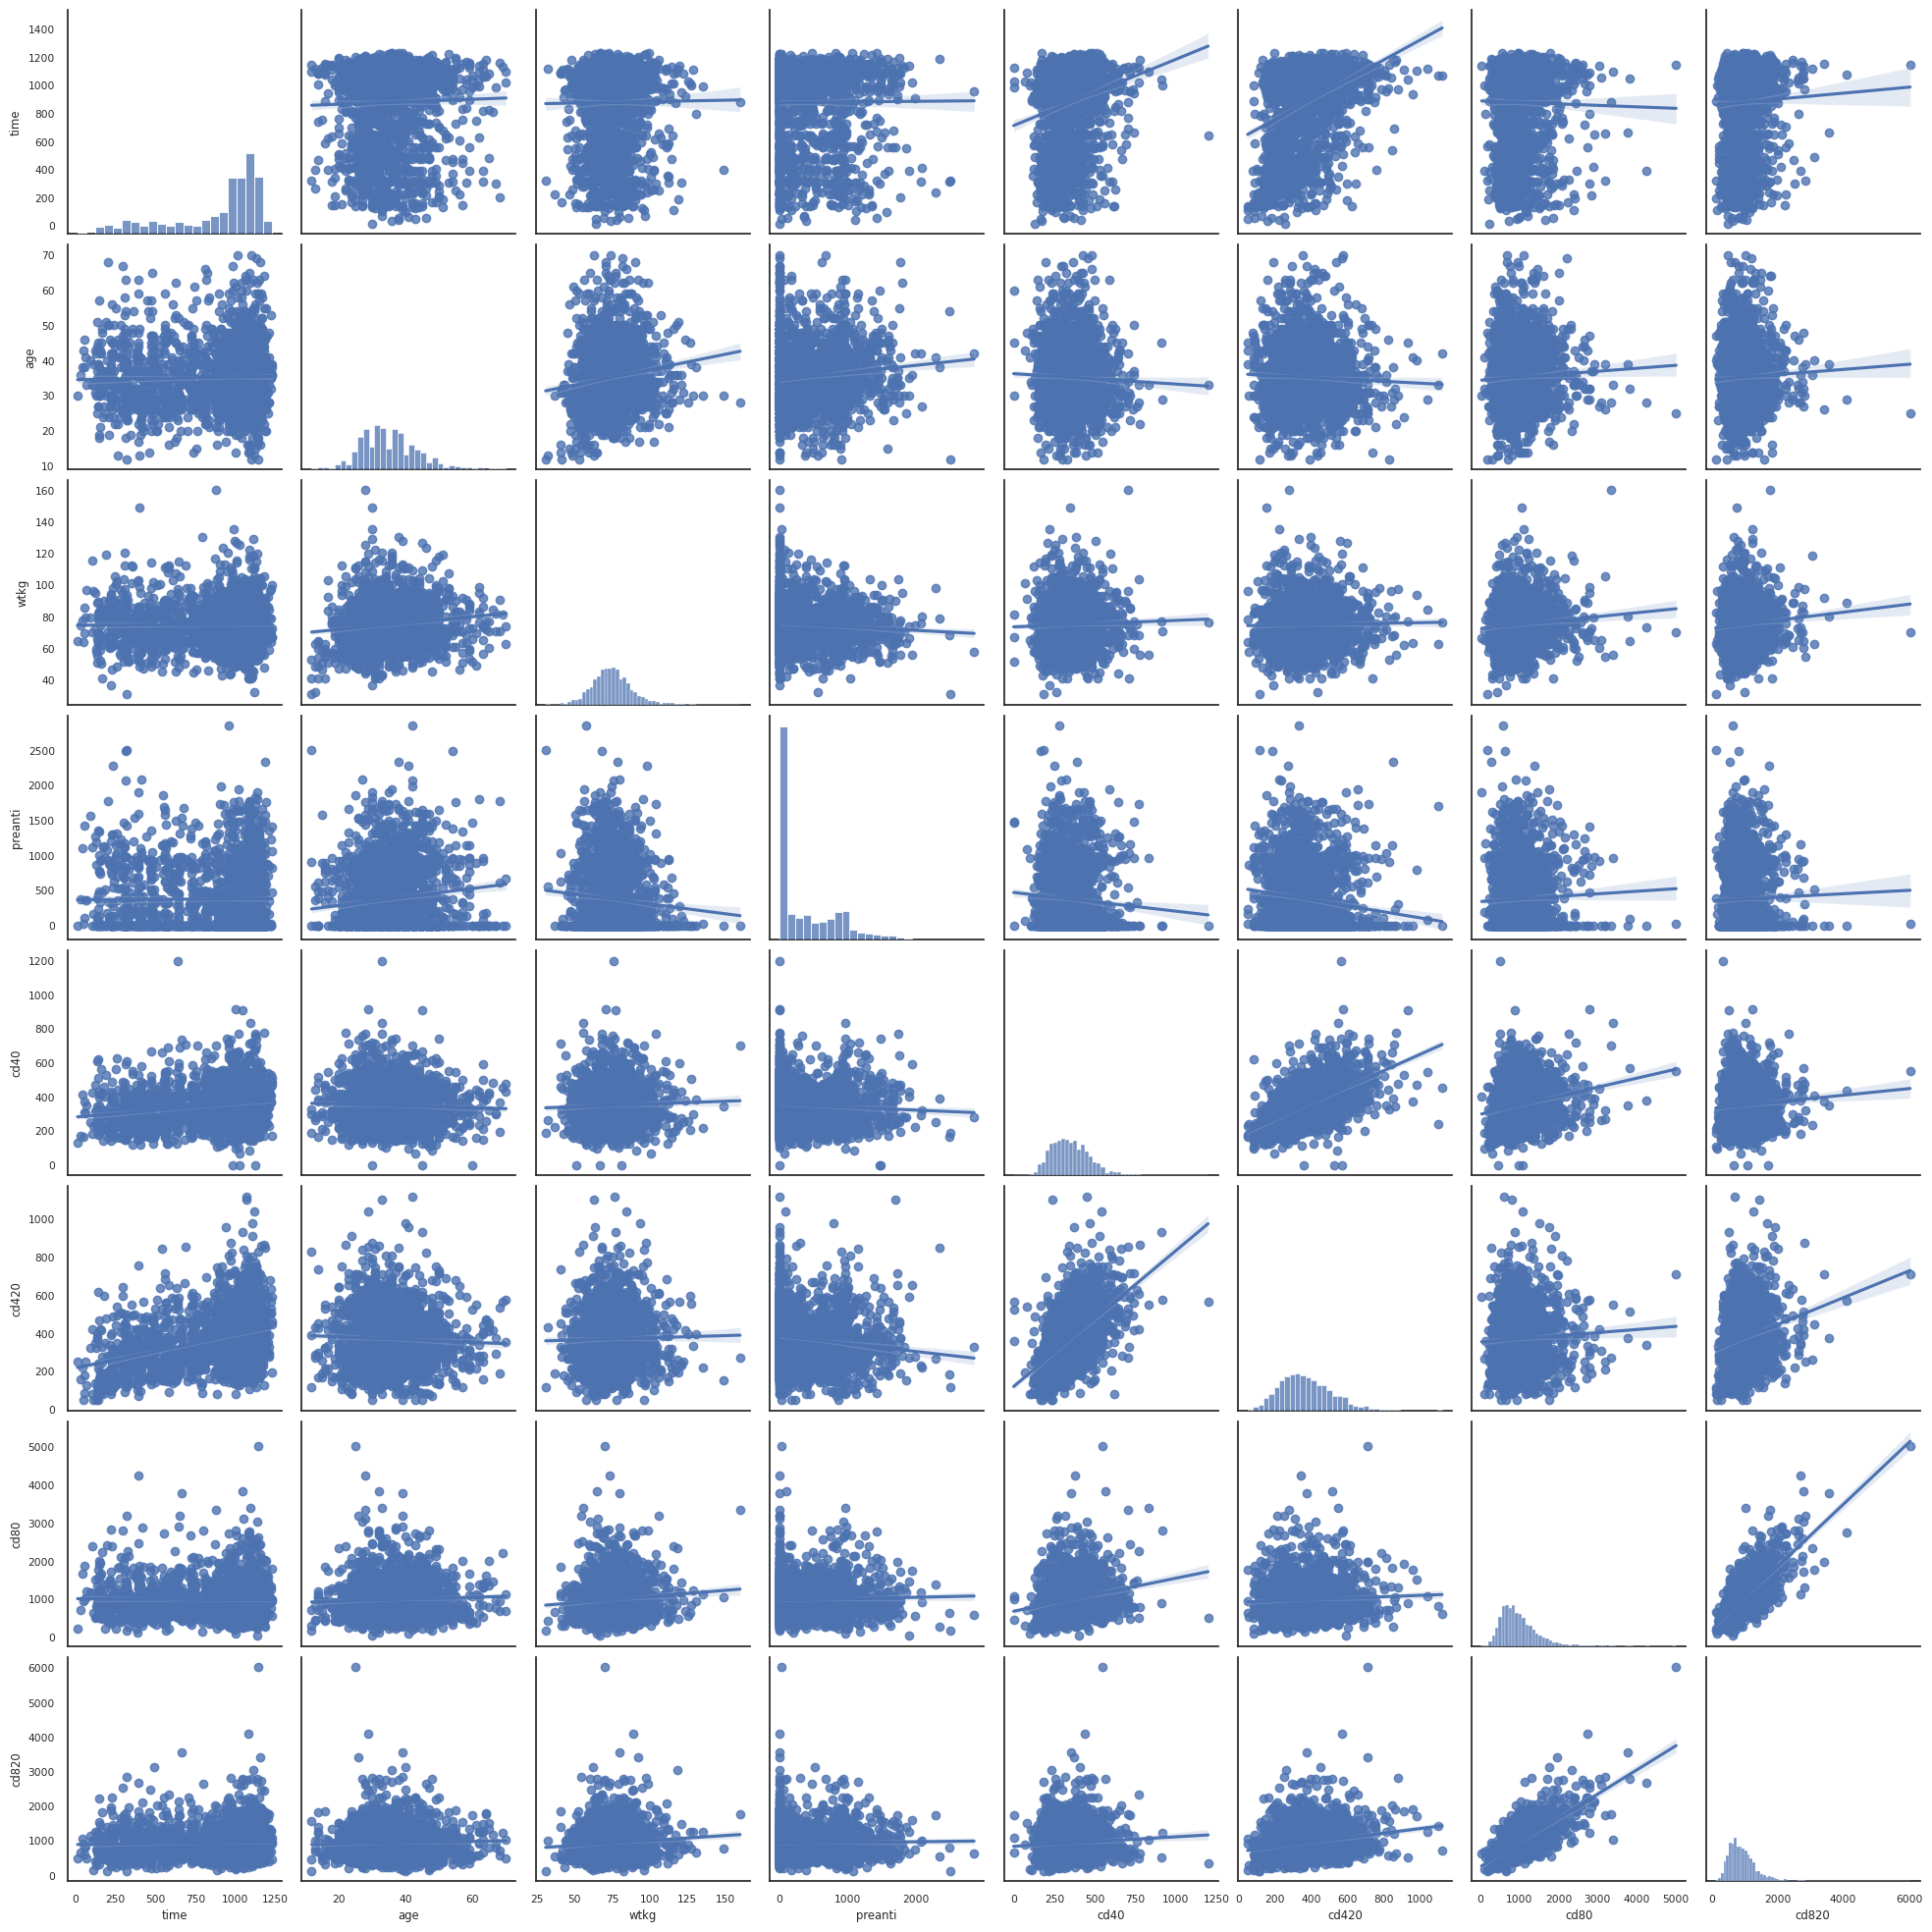

In [32]:
#Pairplot for correlation of numerical Variables
sns.set_context(font_scale=1)
sns.pairplot(df.loc[:, num_cols], kind="reg")
plt.show()

### Relationships of Features with Aids

In [33]:
#creeating correlation matrix
infect_corr = df.corr()["infected"].drop("infected", axis=0)
infect_corr = infect_corr.sort_values(ascending=False)

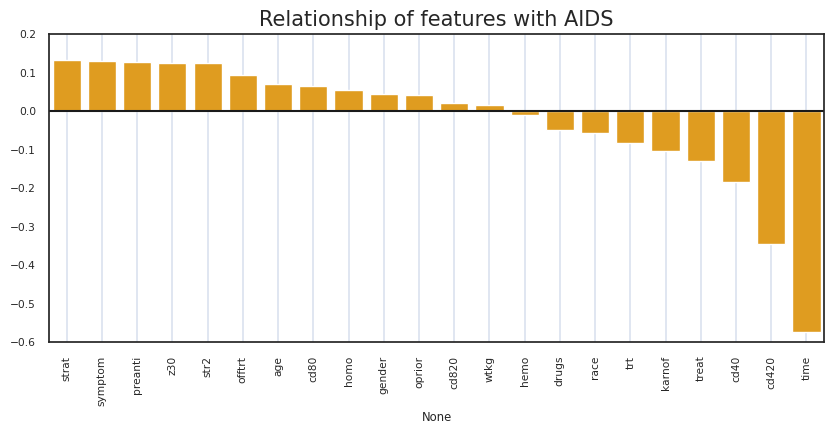

In [34]:
sns.set_style("white")
plt.figure(figsize=(10,4))
sns.barplot(y=infect_corr.values, x=infect_corr.index, color="orange")
plt.axhline(0, color="k")
plt.xticks(rotation=90)
plt.grid(visible=True, axis="x", color="b", lw=0.25)
plt.ylim(-0.6, 0.2)
plt.title("Relationship of features with AIDS", fontsize=15)
plt.show()

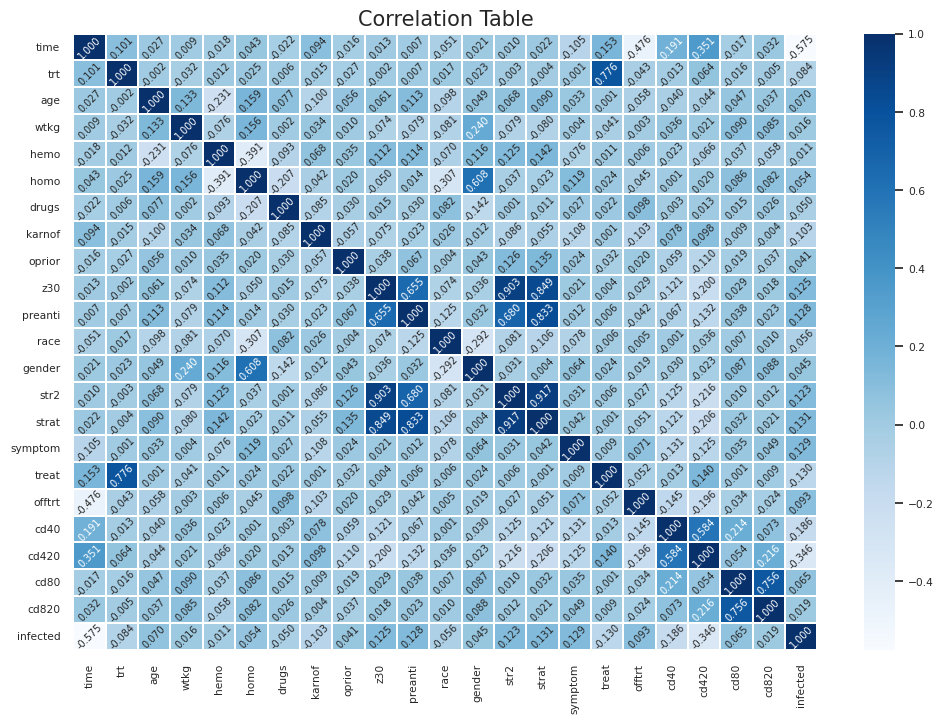

In [35]:
plt.figure(figsize=(12,8))
sns.set(font_scale=0.7)
sns.heatmap(df.corr(), annot=True, annot_kws={"rotation":45, "fontsize":7}, fmt=".3f", linewidths=0.1, cmap="Blues")
plt.title("Correlation Table", fontsize=15)
plt.show()

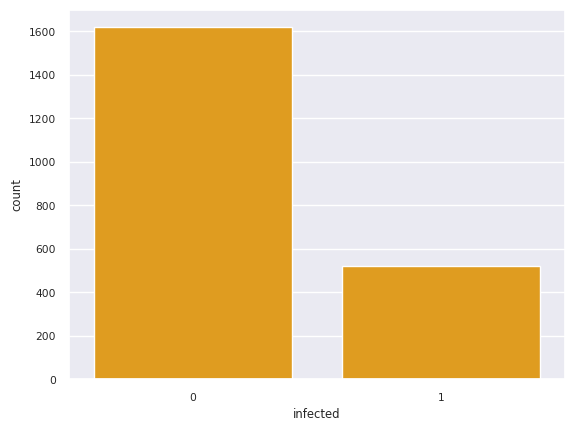

In [36]:
#Count of Infected Variable
sns.countplot(x=df["infected"],color="orange")
plt.show()

### Comments on Distribution of Data

### Diagnosis
- fitness levels(karnof column) do not affect virus immunity in AIDS, because it is distributed in the same fashion in infected and uninfected patients
- Males and white people are more prone to aids->Gender and Race analysis
- Majority of infected patients do not show symptoms(~70%)
- Analysing preanti, days of lower blood lymphocyte levels before antiretroviral therapy started is in the same fashion in infected and uninfected patients
- Anticore levels of the uninfected are much more when compared to the infected. CD4 and CD8 levels after 20 weeks the treatment started can be used as an indicator for diagnosis
### Therapy
- Most of the uninfected patients' therapy ended 4 years after therapy started while infected patients' therapy lasted max for 1200 days.
	- total treatment days can be used as an indicator for classification 
	- people with 1200-1400 of therapy are propbably uninfected
- Majority of infected people had treatment for more than 52 weeks. This emphasizes the duration of the therapy process
- Uninfected people mostly used ZDV-only method, this may indicate the efficiency of this method when compared to others->trt type
### Data Distribution
- ge, weight, preanti, offtrt, homosexuality, drug usage, hemo, variables are distributed almost in the same fashion among infected and uninfected patients
- str2 is correlated with z30. People who started the therapy 30 days before 175 level of Lynfocytes, are more likely to have ZDV: Antiviral medication
- z30 and strat variables are closely correlated. People starting the therapy before lower lymphocyde levels have received therapy more than 52 weeks, this may be because heavier infection cases show symptoms before lymphocyde levels.

## Data Preprocessing
- DataScaling for numerical variables
- SMOTE for imbalanced binary classification
- Categorical variables are already encoded, so we don't have to use one-hut or label-encoding mechanisms

In [37]:
#create a copy of original df
data = df.copy()

In [38]:
data.columns

Index(['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',
       'oprior', 'z30', 'preanti', 'race', 'gender', 'str2', 'strat',
       'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820',
       'infected'],
      dtype='object')

In [39]:
#Standardization
scaler = StandardScaler()
data.iloc[:, 1:9] = scaler.fit_transform(data.iloc[:, 1:9])

In [40]:
y = data["infected"]
X = data.drop("infected", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1497, 22), (1497,), (642, 22), (642,))

In [41]:
#SMOTE for imbalanced classification
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2264, 22), (2264,), (642, 22), (642,))

## Model Selection

- Our data includes a lot of features with complex relationships, for this reason we will use models that can fit to complex data
- We will experiment on Catboost, RandomForestClassifier, MultiLayerPerceptronClassifier, XGBC  and AdaBoost Classifier
- Lastly, we will introduce a Classifier that evaluates the problem by merging all the classifiers at hand

### CatBoostClassifier
- It is a decision-tree based classification model with a feed-back structure.
- Uses gradient-boosting to optimize parameters
- model is split into decision trees which feed the insights they've learned about the data to subsequent decision trees
- final predition is made by combining the predictions from all the trees
- Its strengths are accuracy levels, and handling complex data
- Weaknesses are training speed and interpretability: It is hard to understand the architecture of the algorithm
### XGBC Classifier
- Utilizes gradient boosting as in CatBoostClassifier
- Supports handling missing values flexible in handling categorial features
- Can overfit to data, unlike catboost it does not consider symmetry in decision trees
- Generally a faster and more efficient way to train but less accuracy when compared to CatBoostClassifier
### RandomForestClassifier
- This approach also utilizes Decision trees
- It splits data into managable chunks and trains seperate decision trees with little chunks of data to prevent overfitting
- At each node of the decision trees, a random subset of features is chosen, and the best split among those features is identified to separate the data.
- A new data point is passed through all the decision trees
- Final prediction is made based on majority vote: the highest voted class
### AdaBoost Classifier
- Adaptive Boosting, is a classification model that combines multiple weak models to create a stronger final model.
- Each sub-model focuses on improving the classification performance on the points other nodes misclassified
- Final prediction is made based on a weighted average, More accurate ones take more weights
- It can boost accuracy but is sensitive to noise and therefore prone to overfitting since outliers can significantly effect training process
### MultiLayer Perceptron
- This approach is based on deep neural networks which are feasible to figure out complex relationships among faetures.
- ever layer has its own weights and biases, and an activation function which determines how the data will be transferred to other nodes
- after passing hidden layers, the model makes a prediction on classes and a loss value is calculated using a loss function
- after that, all the weights and biases are updated based on partial derivatives of each with respect to the loss function with a learning-rate.->Gradient Descend
- This optimization Process is done for number of epochs 
### Support Vector Machine
- Its goal is basically to determine most optimal hyperplanes which are vectors that seperate classes in multidimentional vectorspaces
- The key idea is to maximize the margin between the hyperplane and the closest data points from each class, which are called support vectors. These support vectors essentially define the decision boundary of the model.
- It can handle high-dimensional data effectively and is good at finding non-linear relationships
- But it is sensitive to feature-scaling since it makes the predictions based on values on the vectors' each axes.
### Voting Classifier
- Voting Classifier merges multiple classifiers into one general classifier
- It uses either confidence levels of classification models or a maximum vote mechanism to predict the class of a point of data 

In [42]:
#models 
model_list =  [MLPClassifier(max_iter=1000),
              AdaBoostClassifier(), XGBClassifier(),
              CatBoostClassifier(verbose=False),RandomForestClassifier(),SVC()]

In [43]:
warnings.simplefilter(action="ignore", category=FutureWarning)

In [44]:
#models' accuracy  without hyperparameter tuning
model_name_list = []
accuracy_list = []

for model_name in model_list: 
    
    model = model_name
    model_cv = cross_val_score(model,
                               X,
                               y,
                               cv=10,
                               scoring= "accuracy", 
                               n_jobs=-1)
    
    model_name_list.append(model_name.__class__.__name__)
    accuracy_list.append(model_cv.mean())
    
    print(f"{model_name.__class__.__name__} cross validation score: {model_cv.mean()}")
    print("-" * 50)

MLPClassifier cross validation score: 0.7821223289895135
--------------------------------------------------


/home/rosgeek/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/rosgeek/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/rosgeek/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/rosgeek/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

AdaBoostClassifier cross validation score: 0.8784278882014831
--------------------------------------------------
XGBClassifier cross validation score: 0.8812382080645869
--------------------------------------------------
CatBoostClassifier cross validation score: 0.8933987100171119
--------------------------------------------------
RandomForestClassifier cross validation score: 0.8924685182747577
--------------------------------------------------
SVC cross validation score: 0.8494230178579263
--------------------------------------------------


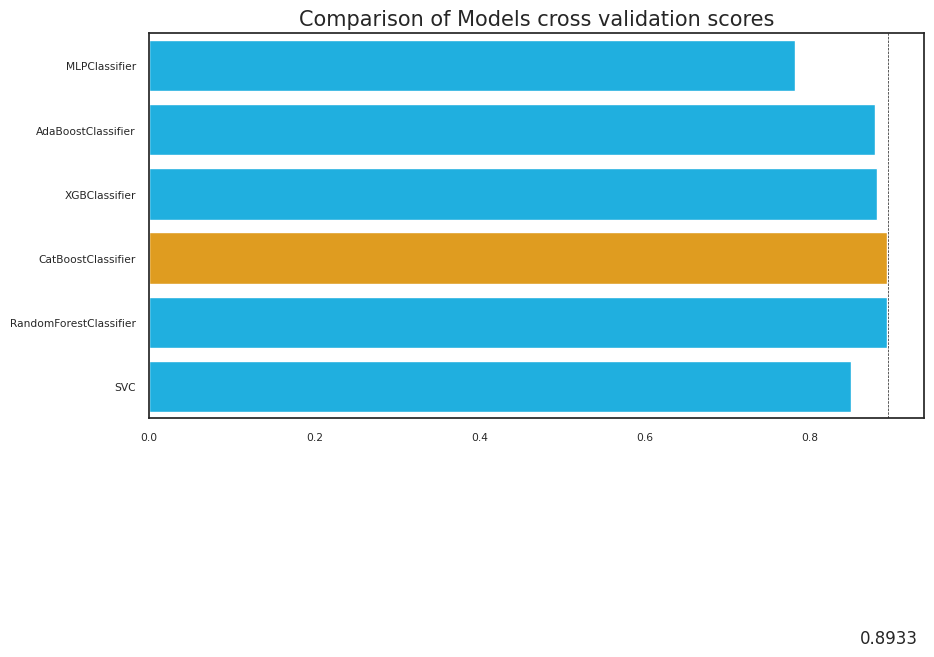

In [45]:
#Graphical Representation
sns.set_style("white")
plt.figure(figsize=(10,5))
clrs = ["orange" if i == max(accuracy_list) else "deepskyblue" for i in accuracy_list]
sns.barplot(x=accuracy_list, y=model_name_list, palette=clrs)
plt.axvline(0.8948, ls="--", lw=0.5, color="k")
plt.text(0.86,9, s="0.8933", fontsize=12)
plt.title("Comparison of Models cross validation scores", fontsize=15)
plt.show()

## HyperParameter Tuning

- We will use optuna which utilizes bayesian optimization for hyperparameter tuning rather than GridSearchCV
- Since we're evaluating performances of multiple classifiers, to save ourselves from too much computation, we prefer Optuna to more classic GridSearchCV

### Important note for hyperparameter tuning

- The hyperparameters I came up with are the result of my research on documentations of all the classifiers I used.
- You can come up with your own by delving into these as I did.Thus, initial low scores  for your models is completely okay

### Voting Classifier
- Again, to save ourselves from a lot of computation, we'll train our Voting classifier with most effective classifiers we've analysed, which are CatBoost, XGBC and RandomForest

### Catboost Hyperparameter-tuning

In [51]:
study = optuna.create_study(direction="maximize")
#The function for optimization for CatBoost
def catboost_objective(trial):
    #Hyperparameter Selection
    params = {
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
        "border_count": trial.suggest_int("border_count", 160, 255, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
    }
    
    model = CatBoostClassifier(**params, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy
study.optimize(catboost_objective, n_trials=80, n_jobs=-1)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

best_catboost = CatBoostClassifier(**study.best_trial.params)

[I 2024-05-06 16:19:42,072] A new study created in memory with name: no-name-e6f8ef03-1e2d-4162-88b2-b8b5f32406f9
[I 2024-05-06 16:19:47,542] Trial 11 finished with value: 0.9034267912772586 and parameters: {'learning_rate': 0.003754155535542947, 'depth': 4, 'l2_leaf_reg': 0.00016622260719604602, 'random_strength': 1.1219925823350366e-07, 'bagging_temperature': 2.296475727049114, 'border_count': 234, 'grow_policy': 'SymmetricTree'}. Best is trial 11 with value: 0.9034267912772586.
[I 2024-05-06 16:19:50,386] Trial 9 finished with value: 0.8909657320872274 and parameters: {'learning_rate': 0.006363433186996685, 'depth': 4, 'l2_leaf_reg': 0.1925772091682607, 'random_strength': 0.0669758466363357, 'bagging_temperature': 0.3568870146685704, 'border_count': 200, 'grow_policy': 'Depthwise'}. Best is trial 11 with value: 0.9034267912772586.
[I 2024-05-06 16:19:51,780] Trial 17 finished with value: 0.8925233644859814 and parameters: {'learning_rate': 0.07013196871005258, 'depth': 4, 'l2_leaf_r

Best trial:
 Value: 0.9065420560747663
 Params: {'learning_rate': 0.003851544433609926, 'depth': 5, 'l2_leaf_reg': 0.024828018889938498, 'random_strength': 0.00012871148208157382, 'bagging_temperature': 1.3926840286644486, 'border_count': 206, 'grow_policy': 'Depthwise'}


### XGBoost Hyperparameter-tuning

In [54]:
study = optuna.create_study(direction="maximize")
#The function for optimization for CatBoost
def xgboost_objective(trial):
    #Hyperparameter Selection
    params = {
        "random_state": 42,
        "max_depth": trial.suggest_int("max_depth", 6, 18),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_int("gamma",1,9),
        "lambda": trial.suggest_float("lambda",0.01,0.5,log=True),
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy
study.optimize(xgboost_objective, n_trials=80, n_jobs=-1)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

best_xgboost = XGBClassifier(**study.best_trial.params)

[I 2024-05-06 16:22:18,524] A new study created in memory with name: no-name-f07d4ed9-db29-4b34-a680-43fd999e3d85
[I 2024-05-06 16:22:18,970] Trial 5 finished with value: 0.897196261682243 and parameters: {'max_depth': 13, 'min_child_weight': 6, 'colsample_bytree': 0.591868124486603, 'eta': 0.1485323577846555, 'gamma': 9, 'lambda': 0.06822050429884902}. Best is trial 5 with value: 0.897196261682243.
[I 2024-05-06 16:22:18,976] Trial 0 finished with value: 0.8925233644859814 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'colsample_bytree': 0.7108628661043088, 'eta': 0.17653668275409698, 'gamma': 6, 'lambda': 0.20509168163108227}. Best is trial 5 with value: 0.897196261682243.
[I 2024-05-06 16:22:19,047] Trial 11 finished with value: 0.8894080996884736 and parameters: {'max_depth': 13, 'min_child_weight': 2, 'colsample_bytree': 0.7645339276074079, 'eta': 0.2304552623134081, 'gamma': 6, 'lambda': 0.010902253617585763}. Best is trial 5 with value: 0.897196261682243.
[I 2024-05-

Best trial:
 Value: 0.9034267912772586
 Params: {'max_depth': 7, 'min_child_weight': 7, 'colsample_bytree': 0.6390539014833039, 'eta': 0.11099479574674771, 'gamma': 8, 'lambda': 0.4957654542360455}


### Random Forest Classifier  Hyperparameter-tuning

In [55]:
#Random Forest Classifier
study = optuna.create_study(direction="maximize")
#The function for optimization for CatBoost
def rfclf_objective(trial):
    #Hyperparameter Selection
    params = {
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_features": trial.suggest_float("max_features",0.2, 0.9, step=0.1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2,10),
        "max_depth": trial.suggest_int("max_depth", 6, 25),
    }
    model = RandomForestClassifier(**params, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy
study.optimize(rfclf_objective, n_trials=80, n_jobs=-1)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

best_rfclf = RandomForestClassifier(**study.best_trial.params)

[I 2024-05-06 16:22:35,281] A new study created in memory with name: no-name-b895c44c-f7ce-445b-bed7-02eae4446d02
[I 2024-05-06 16:22:42,089] Trial 13 finished with value: 0.9065420560747663 and parameters: {'n_estimators': 200, 'max_features': 0.2, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_depth': 14}. Best is trial 13 with value: 0.9065420560747663.
[I 2024-05-06 16:22:43,263] Trial 9 finished with value: 0.8940809968847352 and parameters: {'n_estimators': 200, 'max_features': 0.8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 7}. Best is trial 13 with value: 0.9065420560747663.
[I 2024-05-06 16:22:43,498] Trial 1 finished with value: 0.8894080996884736 and parameters: {'n_estimators': 200, 'max_features': 0.9, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_depth': 13}. Best is trial 13 with value: 0.9065420560747663.
[I 2024-05-06 16:22:43,725] Trial 18 finished with value: 0.8878504672897196 and parameters: {'n_estimators': 200, 'max_features': 0.9, '

Best trial:
 Value: 0.9065420560747663
 Params: {'n_estimators': 200, 'max_features': 0.2, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_depth': 14}


In [59]:
#Merging all the models using voting classifier using soft-voting
voting = VotingClassifier(estimators= [("CatBoost", best_catboost),
                                       ("XGBoost", best_xgboost),
                                       ("RandomForest", best_rfclf)],
                         voting="soft",
                         n_jobs=-1) 
voting_fit = voting.fit(X_train, y_train)

### Accuracy Levels

In [60]:
accuracy_list = []

for clf in (best_catboost, best_xgboost, best_rfclf, voting_fit):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)
    print(f"{clf.__class__.__name__} :  {accuracy_score(y_test, y_pred):.3f}")

CatBoostClassifier :  0.905
XGBClassifier :  0.896
RandomForestClassifier :  0.899
VotingClassifier :  0.903


## Classification Reports

In [61]:
for clf in (best_catboost, best_xgboost, best_rfclf, voting_fit):
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    clas_report = classification_report(y_test, y_pred)
    print(f"\n----------------- {model.__class__.__name__} -----------------\n")
    print(clas_report)


----------------- CatBoostClassifier -----------------

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       486
           1       0.81      0.80      0.80       156

    accuracy                           0.90       642
   macro avg       0.87      0.87      0.87       642
weighted avg       0.90      0.90      0.90       642


----------------- XGBClassifier -----------------

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       486
           1       0.78      0.79      0.79       156

    accuracy                           0.90       642
   macro avg       0.86      0.86      0.86       642
weighted avg       0.90      0.90      0.90       642


----------------- RandomForestClassifier -----------------

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       486
           1       0.78      0.78      0.78       156

    accuracy

## Confusion Matrices

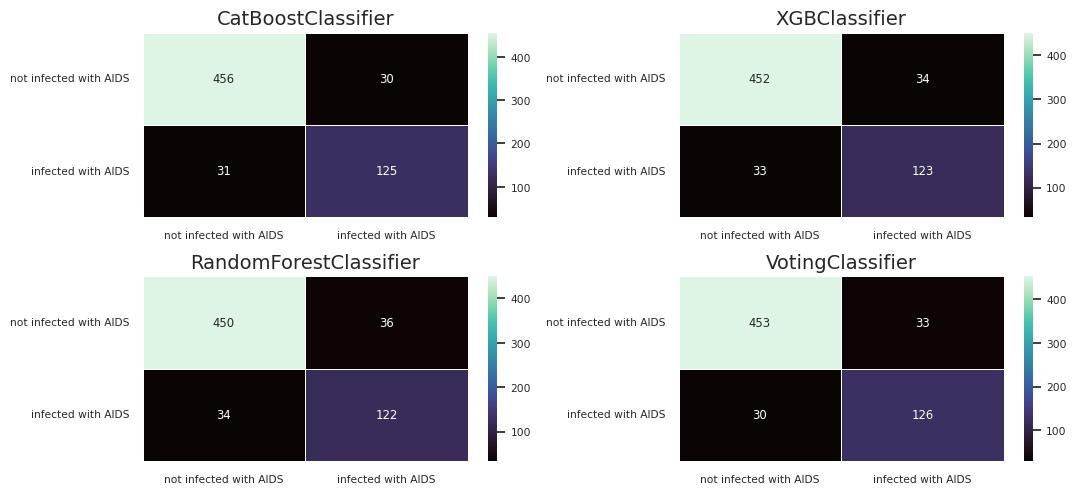

In [62]:
plt.figure(figsize=(11, 5))
sns.set_context(font_scale=0.7)
j = 0
for i in (best_catboost, best_xgboost, best_rfclf, voting_fit):
    model = i.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2,2, j+1)
    sns.heatmap(cm, annot=True, fmt="g", cmap="mako", linewidths=0.5,
                xticklabels=["not infected with AIDS", "infected with AIDS"],
                yticklabels=["not infected with AIDS", "infected with AIDS"])
    plt.title(f"{model.__class__.__name__}", fontsize=14)
    j += 1
plt.tight_layout()
plt.show()

## Feature Importance

- Now that we trained our models to predict aids infection on a patient, we'll display which features are the ones that matter most to our models
- For this, I'll use the model with highest accuracy, which is CatBoostClassifier

In [64]:
cat_boost = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
data_feature_importance = pd.DataFrame(cat_boost.feature_importances_, columns=["feature_importance"])
data_feature_importance["features"] = data.columns[1:]
data_feature_importance = data_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)

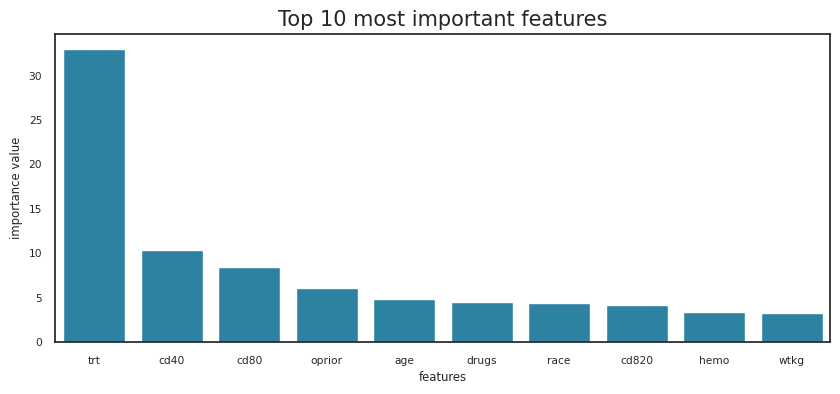

In [65]:
sns.set_style("white")
plt.figure(figsize=(10,4))
sns.barplot(y=data_feature_importance.feature_importance[:10],
            x=data_feature_importance.features[:10], color="#1b8bb4")
plt.ylabel("importance value")
plt.title("Top 10 most important features", fontsize=15)
plt.show()

- As we have predicted from our explaratory data analysis, type of treatment the patient undergoes was the most important feature in diagnosis of AIDS.
- Other than that, blood lymphocyte levels also impact infection